크리스마스

In [2]:
import pandas as pd
import numpy as np

ts = pd.read_csv("../../notebooks/member1/DATA/transactions_processed.csv")
cs = pd.read_csv("../../notebooks/member1/DATA/customers_processed.csv")
ac = pd.read_csv("../../notebooks/member1/DATA/articles_processed.csv")

In [3]:
# 1) 타입 정리 (핵심: 날짜/가격/조인키)
ts = ts.copy()
cs = cs.copy()
ac = ac.copy()

# 날짜
ts["T_Dat"] = pd.to_datetime(ts["T_Dat"], errors="coerce")

# Year_Month는 T_Dat 기준으로 "YYYY-MM"로 통일 (이미 있어도 덮어씀)
ts["Year_Month"] = ts["T_Dat"].dt.to_period("M").astype(str)

# 가격 (숫자로)
ts["Price"] = pd.to_numeric(ts["Price"], errors="coerce")

# 조인 키 타입 통일
# Customer_Id는 길이가 긴 문자열이니까 문자열로 통일
ts["Customer_Id"] = ts["Customer_Id"].astype("string")
cs["Customer_Id"] = cs["Customer_Id"].astype("string")

# Article_Id는 숫자 형태로 통일 (혹시 문자열로 들어왔으면 숫자로)
ts["Article_Id"] = pd.to_numeric(ts["Article_Id"], errors="coerce").astype("Int64")
ac["Article_Id"] = pd.to_numeric(ac["Article_Id"], errors="coerce").astype("Int64")

In [4]:
ts.columns = ts.columns.str.strip().str.title().str.replace(" ", "_")
cs.columns = cs.columns.str.strip().str.title().str.replace(" ", "_")
ac.columns = ac.columns.str.strip().str.title().str.replace(" ", "_")


In [14]:
# 1) transactions + articles
merged = ts.merge(
    ac,
    on="Article_Id",
    how="left",
    validate="many_to_one"
)

# 2) + customers
merged = merged.merge(
    cs,
    on="Customer_Id",
    how="left",
    validate="many_to_one"
)

print("merged shape:", merged.shape)
print("merged columns:", merged.columns.tolist())
merged.head()


merged shape: (1040101, 26)
merged columns: ['T_Dat', 'Customer_Id', 'Article_Id', 'Price', 'Sales_Channel_Id', 'Channel_Label', 'Year_Month', 'Product_Code', 'Prod_Name', 'Product_Group_Name', 'Product_Type', 'Graphical_Appearance', 'Colour_Group', 'Perceived_Colour_Value', 'Perceived_Colour_Master', 'Department', 'Index', 'Index_Group', 'Section', 'Garment_Group', 'Club_Member_Status', 'Fashion_News_Frequency', 'Age', 'Fn_Label', 'Active_Label', 'Age_Band']


,T_Dat,Customer_Id,Article_Id,Price,Sales_Channel_Id,Channel_Label,Year_Month,Product_Code,Prod_Name,Product_Group_Name,...,Index,Index_Group,Section,Garment_Group,Club_Member_Status,Fashion_News_Frequency,Age,Fn_Label,Active_Label,Age_Band
0,2019-11-05,3e2b60b679e62fb49516105b975560082922011dd752ec...,698328010,0.016932,2,온라인,2019-11,698328,Zebra Cf Tvp,Garment Upper Body,...,Divided(D),Divided(2),Divided Collection(53),Jersey Fancy(1005),ACTIVE,REGULARLY,51.0,구독,활성,50대
1,2019-05-22,89647ac2274f54c770aaa4b326e0eea09610c252381f37...,760597002,0.033881,2,온라인,2019-05,760597,Bubble Wrap Top,Garment Upper Body,...,Ladieswear(A),Ladieswear(1),Womens Casual(6),Jersey Fancy(1005),ACTIVE,NONE,28.0,미구독,비활성,20대
2,2019-05-10,2ebe392150feb60ca89caa8eff6c08b7ef1138cd6fdc71...,488561032,0.016932,2,온라인,2019-05,488561,Teddy Jogger.,Garment Lower Body,...,Menswear(F),Menswear(3),Contemporary Casual(21),Shorts(1025),ACTIVE,REGULARLY,37.0,구독,활성,30대
3,2019-08-26,7b3205de4ca17a339624eb5e3086698e9984eba6b47c56...,682771001,0.033881,2,온라인,2019-08,682771,Yuki Shopper,Accessories,...,Ladies Accessories(C),Ladieswear(1),Womens Big Accessories(65),Accessories(1019),ACTIVE,NONE,19.0,미구독,비활성,10대
4,2019-08-10,3b77905de8b32045f08cedb79200cdfa477e9562429a39...,742400033,0.003220,1,오프라인,2019-08,742400,1Pk Sportsock,Socks & Tights,...,Menswear(F),Menswear(3),Men Underwear(26),Socks And Tights(1021),ACTIVE,NONE,35.0,미구독,비활성,30대


##전체적인 월별 매출 파악하기! / 어떤 달이 매출이 가장 클지에 대해서 기본적인 확인

최고 매출 월: 2019-06 | Total_Price: 3088.776976142


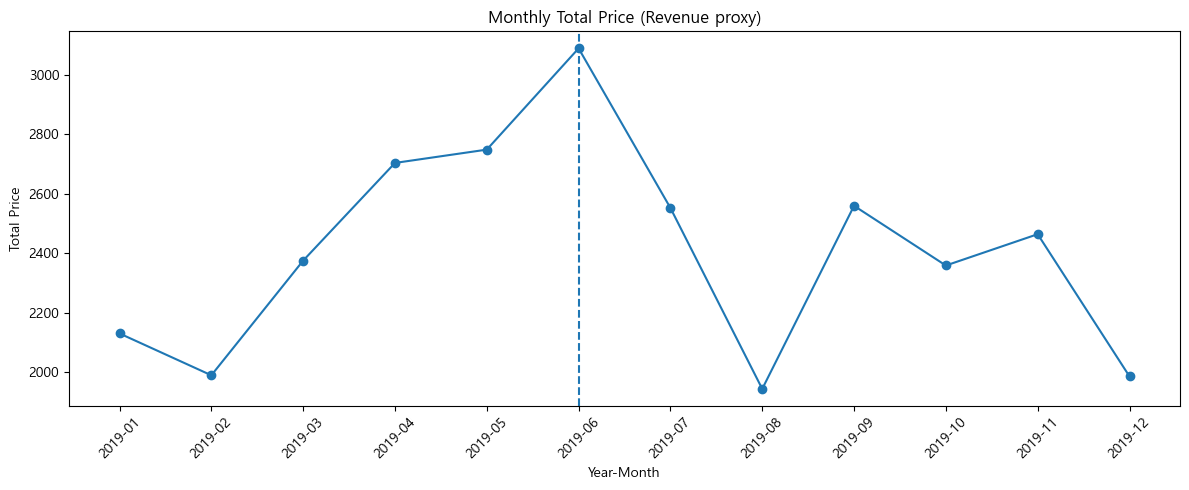

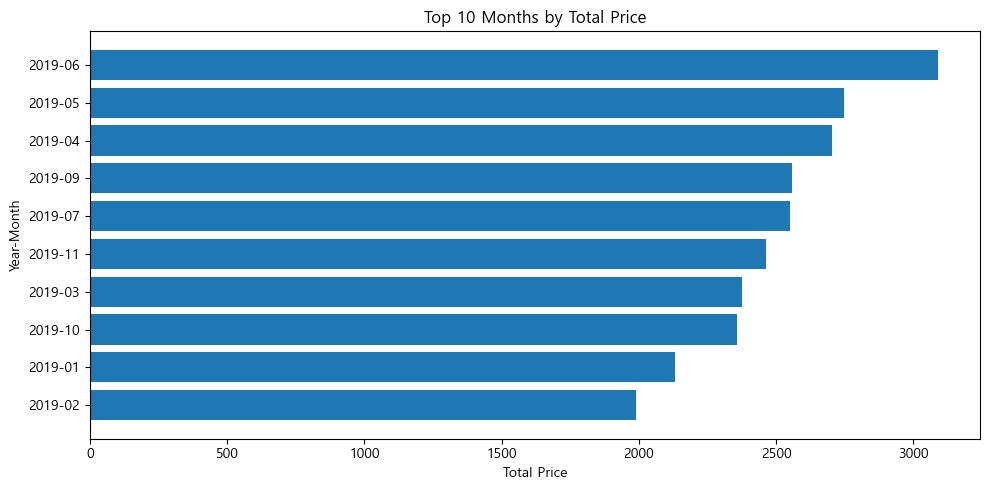

In [15]:
# 월별 매출(=Price 합) 가장 큰 달 확인 + 시각화
# 전제: ts 데이터프레임에 'Year_Month', 'Price' 컬럼 존재 (지금 네 ts 기준 OK)

import pandas as pd
import matplotlib.pyplot as plt

# 1) 월별 매출(Price 합) 집계
monthly_sales = (
    ts.groupby("Year_Month", as_index=False)["Price"]
      .sum()
      .rename(columns={"Price": "Total_Price"})
      .sort_values("Year_Month")
)

# 2) 최고 매출 월 찾기
top_row = monthly_sales.loc[monthly_sales["Total_Price"].idxmax()]
top_month = top_row["Year_Month"]
top_value = top_row["Total_Price"]

print("최고 매출 월:", top_month, "| Total_Price:", top_value)

# 3) 라인 차트 (최고 월 표시)
plt.figure(figsize=(12,5))
plt.plot(monthly_sales["Year_Month"], monthly_sales["Total_Price"], marker="o")
plt.xticks(rotation=45)
plt.title("Monthly Total Price (Revenue proxy)")
plt.xlabel("Year-Month")
plt.ylabel("Total Price")

# 최고 월에 세로선 표시
plt.axvline(x=top_month, linestyle="--")
plt.tight_layout()
plt.show()

# 4) 월별 매출 TOP 10 막대 그래프 (보기 좋게)
top10 = monthly_sales.sort_values("Total_Price", ascending=False).head(10).sort_values("Total_Price")

plt.figure(figsize=(10,5))
plt.barh(top10["Year_Month"], top10["Total_Price"])
plt.title("Top 10 Months by Total Price")
plt.xlabel("Total Price")
plt.ylabel("Year-Month")
plt.tight_layout()
plt.show()


In [16]:
import pandas as pd

monthly = (
    ts.groupby("Year_Month", as_index=False)
      .agg(
          Txn_Count=("Price", "size"),                 # 거래건수(행 개수)
          Buyer_Count=("Customer_Id", "nunique"),      # 구매자 수
          Total_Price=("Price", "sum"),                # 구매단가 총합(매출 proxy)
          Avg_Price_per_Txn=("Price", "mean")          # 거래 1건당 평균 Price
      )
      .sort_values("Year_Month")
)

monthly.head()


,Year_Month,Txn_Count,Buyer_Count,Total_Price,Avg_Price_per_Txn
0,2019-01,80485,61901,2129.926131,0.026464
1,2019-02,73073,57369,1989.217641,0.027222
2,2019-03,81127,62360,2374.905504,0.029274
3,2019-04,93289,70184,2703.443538,0.028979
4,2019-05,98958,74332,2748.199469,0.027771


## 매출총액 vs 거래총건수
## => 인사이트 1. 거래건수가 많다고 해서 매출총액이 높은 것은 아니다!

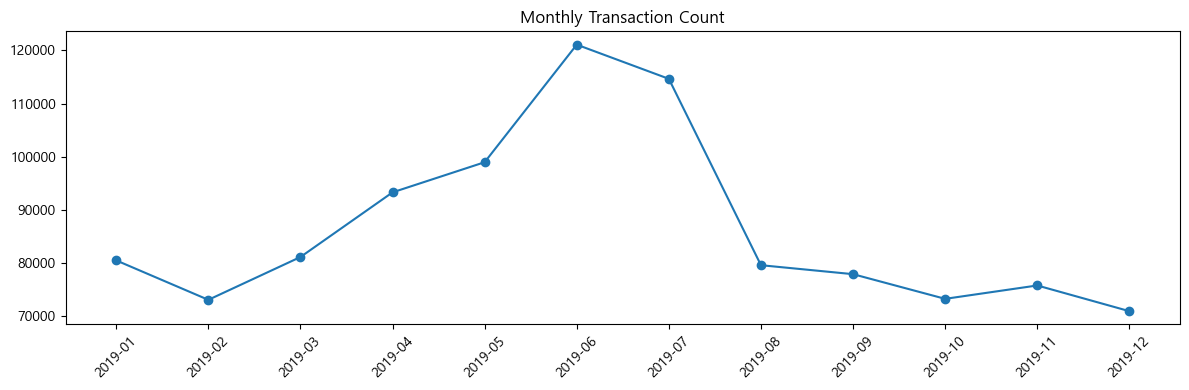

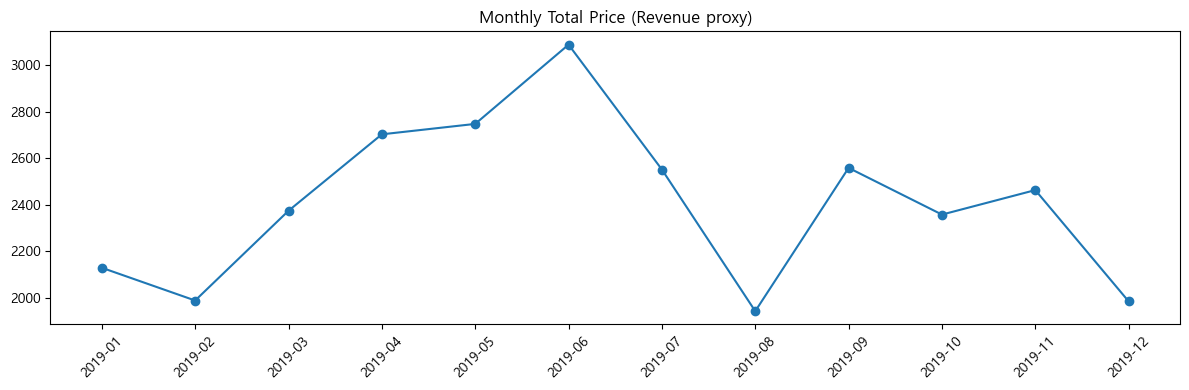

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(monthly["Year_Month"], monthly["Txn_Count"], marker="o")
plt.xticks(rotation=45)
plt.title("Monthly Transaction Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(monthly["Year_Month"], monthly["Total_Price"], marker="o")
plt.xticks(rotation=45)
plt.title("Monthly Total Price (Revenue proxy)")
plt.tight_layout()
plt.show()


## 나이대별 거래량(건수) + 매출(Price 합)

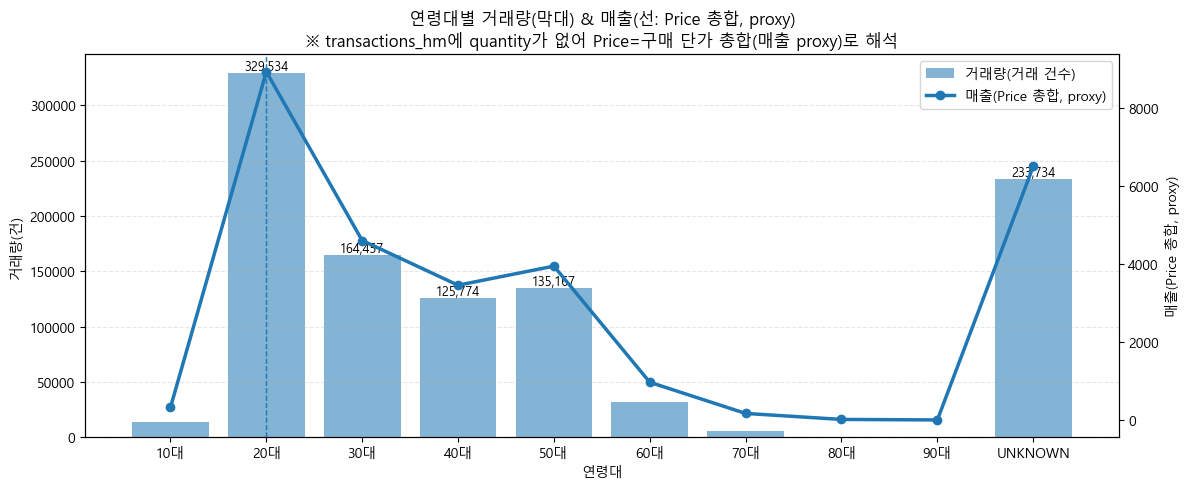

=== Age summary (check) ===


,Age_Band,Txn_Count,Total_Price,Buyer_Count
0,10대,13641,322.263542,8697
1,20대,329534,8926.809731,145921
2,30대,164457,4600.670297,66100
3,40대,125774,3454.672994,53264
4,50대,135167,3944.068062,60761
5,60대,31847,966.908049,15584
6,70대,5495,167.941084,2989
7,80대,415,13.881576,224
8,90대,37,1.048949,20
9,UNKNOWN,233734,6498.637871,104675


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 0) 한글 폰트(Windows / VSCode Jupyter)
# -----------------------------
plt.rcParams["font.family"] = "Malgun Gothic"   # 맑은 고딕
plt.rcParams["axes.unicode_minus"] = False

# -----------------------------
# 1) 연령대별 집계 (같은 기준으로!)
#   - 거래량: Txn_Count (row 수)
#   - 매출(Proxy): Total_Price (Price 합)
#   - 구매자수: Buyer_Count (고유 고객수)
# -----------------------------
age_summary = (
    merged.groupby("Age_Band", dropna=False)
    .agg(
        Txn_Count=("Price", "size"),
        Total_Price=("Price", "sum"),
        Buyer_Count=("Customer_Id", "nunique"),
    )
    .reset_index()
)

# 결측/빈칸 처리 (혹시 모르니 안전장치)
age_summary["Age_Band"] = age_summary["Age_Band"].fillna("UNKNOWN").astype(str).str.strip()
age_summary.loc[age_summary["Age_Band"].eq(""), "Age_Band"] = "UNKNOWN"

# -----------------------------
# 2) x축 순서 지정 (10대~90대, UNKNOWN 마지막)
# -----------------------------
order = ["10대","20대","30대","40대","50대","60대","70대","80대","90대","UNKNOWN"]
age_summary["Age_Band"] = pd.Categorical(age_summary["Age_Band"], categories=order, ordered=True)
age_summary = age_summary.sort_values("Age_Band")

# 혹시 카테고리에 없는 값이 있으면 뒤로 붙이기
missing_cats = age_summary[age_summary["Age_Band"].isna()]
if len(missing_cats) > 0:
    # 카테고리 밖 값은 문자열로 다시 살려서 마지막에 붙임
    tmp = (
        merged.groupby("Age_Band", dropna=False)
        .agg(Txn_Count=("Price","size"), Total_Price=("Price","sum"), Buyer_Count=("Customer_Id","nunique"))
        .reset_index()
    )
    tmp["Age_Band"] = tmp["Age_Band"].fillna("UNKNOWN").astype(str).str.strip()
    tmp.loc[tmp["Age_Band"].eq(""), "Age_Band"] = "UNKNOWN"
    # order에 없는 값만 따로
    extra = tmp[~tmp["Age_Band"].isin(order)].sort_values("Total_Price", ascending=False)
    # 기본 order + extra + UNKNOWN(중복 제거)
    new_order = [x for x in order if x != "UNKNOWN"] + extra["Age_Band"].tolist() + ["UNKNOWN"]
    tmp["Age_Band"] = pd.Categorical(tmp["Age_Band"], categories=new_order, ordered=True)
    age_summary = tmp.sort_values("Age_Band")

# -----------------------------
# 3) 시각화 (막대=거래량, 선=매출 proxy)
#   - 선이 막대 뒤에 가려지지 않게 zorder 지정
#   - 최대값 점선(막대/선 각각)
#   - 막대에 라벨(거래량) 붙이기
# -----------------------------
x = age_summary["Age_Band"].astype(str)
txn = age_summary["Txn_Count"]
sales = age_summary["Total_Price"]

fig, ax1 = plt.subplots(figsize=(12, 5))

# 막대(거래량) 먼저
bars = ax1.bar(x, txn, alpha=0.55, label="거래량(거래 건수)", zorder=1)
ax1.set_xlabel("연령대")
ax1.set_ylabel("거래량(건)")
ax1.grid(axis="y", linestyle="--", alpha=0.3, zorder=0)

# 막대 최대값 점선
txn_max_idx = txn.idxmax()
txn_max_x = x.iloc[list(age_summary.index).index(txn_max_idx)] if txn_max_idx in age_summary.index else x.iloc[txn.argmax()]
ax1.axvline(x=x.iloc[txn.argmax()], linestyle="--", linewidth=1, alpha=0.7)

# 막대 라벨(너무 많으면 지저분하니 상위 몇 개만)
top_k = 5
top_idx = txn.sort_values(ascending=False).head(top_k).index
for i, r in enumerate(bars):
    band = x.iloc[i]
    h = r.get_height()
    if age_summary.iloc[i].name in top_idx:  # 상위 top_k만 라벨
        ax1.text(r.get_x() + r.get_width()/2, h, f"{int(h):,}",
                 ha="center", va="bottom", fontsize=9)

# 선(매출 proxy)은 오른쪽 축
ax2 = ax1.twinx()
ax2.plot(x, sales, marker="o", linewidth=2.5, label="매출(Price 총합, proxy)", zorder=3)
ax2.set_ylabel("매출(Price 총합, proxy)")

# 선 최대값 점선
sales_max_pos = sales.values.argmax()
ax1.axvline(x=x.iloc[sales_max_pos], linestyle="--", linewidth=1, alpha=0.7)

# 선이 위로 잘 보이도록(막대보다 앞으로)
ax2.set_zorder(ax1.get_zorder() + 1)
ax2.patch.set_visible(False)

# 제목/범례
plt.title("연령대별 거래량(막대) & 매출(선: Price 총합, proxy)\n")

# 범례 합치기
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc="upper right")

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# -----------------------------
# 4) 검증 출력
# -----------------------------
print("=== Age summary (check) ===")
display(age_summary)


In [12]:
bad = age_summary[(age_summary["Txn_Count"] == 0) & (age_summary["Total_Price"] > 0)]
print("이상 케이스 개수:", len(bad))
display(bad)

이상 케이스 개수: 0


,Age_Band,Txn_Count,Total_Price,Buyer_Count


## 온라인/오프라인 매출(Price 합, proxy)


In [19]:
# 온라인/오프라인 매출(Price 합, proxy)
channel_sales = (
    merged.groupby("Channel_Label", dropna=False)
    .agg(
        Txn_Count=("Price", "size"),
        Total_Sales=("Price", "sum"),
        Avg_Price=("Price", "mean"),
        Buyer_Count=("Customer_Id", "nunique"),
    )
    .reset_index()
)

channel_sales["Sales_Share"] = channel_sales["Total_Sales"] / channel_sales["Total_Sales"].sum()

display(channel_sales.sort_values("Total_Sales", ascending=False))
print("총 매출(Price 합, proxy):", channel_sales["Total_Sales"].sum())


,Channel_Label,Txn_Count,Total_Sales,Avg_Price,Buyer_Count,Sales_Share
1,온라인,721488,21624.710388,0.029972,322659,0.74834
0,오프라인,318613,7272.191768,0.022825,203581,0.25166


총 매출(Price 합, proxy): 28896.902156661003


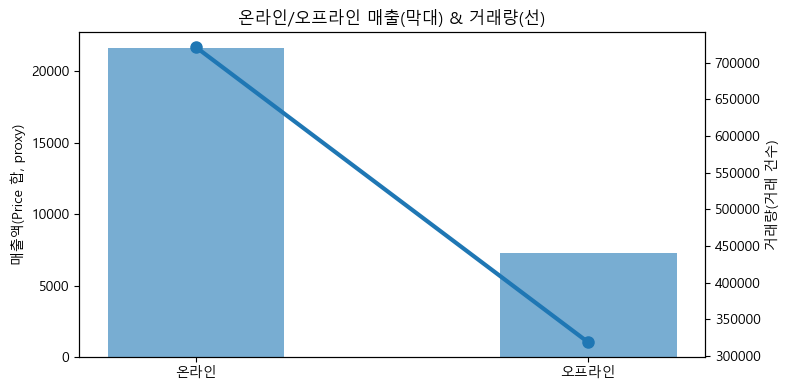

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

# 집계
channel_sales = (
    merged.groupby("Channel_Label", dropna=False)
    .agg(
        Txn_Count=("Price", "size"),
        Total_Sales=("Price", "sum"),
    )
    .reset_index()
)

# 원하는 순서(있으면)로 정렬
order = ["온라인", "오프라인"]
channel_sales["Channel_Label"] = channel_sales["Channel_Label"].astype(str).str.strip()
channel_sales["order"] = channel_sales["Channel_Label"].map({k:i for i,k in enumerate(order)}).fillna(999)
channel_sales = channel_sales.sort_values("order").drop(columns="order")

x = channel_sales["Channel_Label"].tolist()
sales = channel_sales["Total_Sales"].tolist()
txn = channel_sales["Txn_Count"].tolist()

fig, ax1 = plt.subplots(figsize=(8,4))

#  막대: 얇게(폭 조절) + 약간 투명
bar_width = 0.45
bars = ax1.bar(x, sales, width=bar_width, alpha=0.6, zorder=1)
ax1.set_ylabel("매출액(Price 합, proxy)")

#  선: 위로(레이어 최상) + 굵게
ax2 = ax1.twinx()
ax2.plot(
    x, txn,
    marker="o",
    linewidth=3,
    markersize=8,
    zorder=10
)
ax2.set_ylabel("거래량(거래 건수)")

#  선이 막대보다 위에 확실히 보이게(트릭: twin 축 패치 투명 + zorder)
ax2.set_zorder(ax1.get_zorder() + 1)
ax2.patch.set_visible(False)

plt.title("온라인/오프라인 매출(막대) & 거래량(선)")
plt.tight_layout()
plt.show()


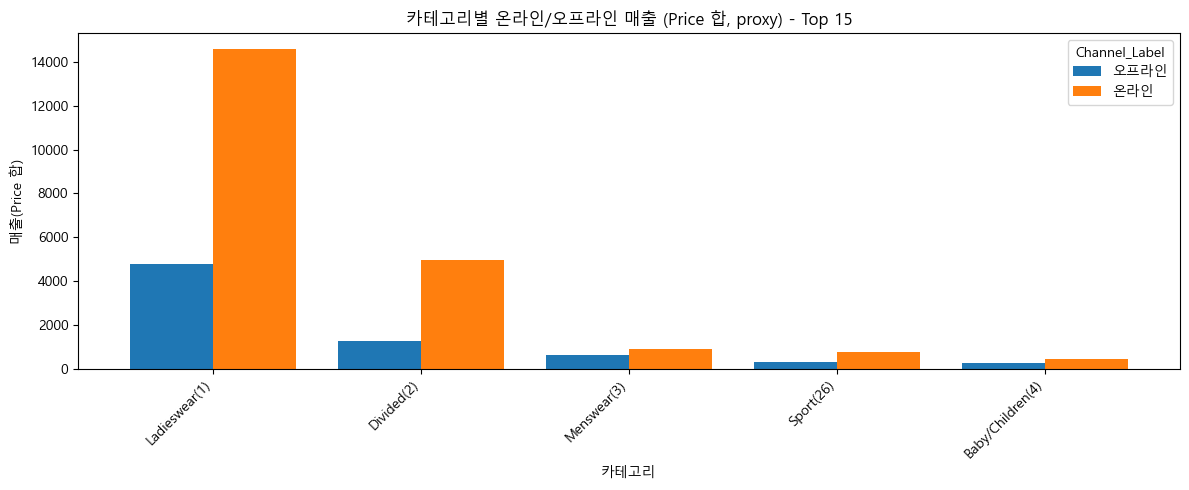

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

# 0) 컬럼 확인(혹시 너는 Index_Group 대신 Index를 쓰는 경우도 있어서 안전장치)
cat_col = "Index_Group" if "Index_Group" in merged.columns else "Index"  # 카테고리 컬럼
channel_col = "Channel_Label"  # 온라인/오프라인
value_col = "Price"            # 매출 proxy

# 1) 카테고리 x 채널 매출 집계
pivot = (
    merged.pivot_table(
        index=cat_col,
        columns=channel_col,
        values=value_col,
        aggfunc="sum",
        fill_value=0
    )
)

# 2) 보기 좋게 (총매출 큰 순서 상위 N개만)
pivot["Total"] = pivot.sum(axis=1)
pivot = pivot.sort_values("Total", ascending=False).drop(columns="Total")

TOP_N = 15  # 너무 많으면 보기 힘들어서 상위 15개만
plot_df = pivot.head(TOP_N)

# 3) 그룹드 바(온라인/오프라인 나란히)
ax = plot_df.plot(kind="bar", figsize=(12,5), width=0.8)  # 색은 자동

ax.set_title(f"카테고리별 온라인/오프라인 매출 (Price 합, proxy) - Top {TOP_N}")
ax.set_xlabel("카테고리")
ax.set_ylabel("매출(Price 합)")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## 크리스마스 매출 극대화를 위한 매출분석

=> 가설
1. 크리스마스 시즌에는 빨간색, 흰색, 초록색 의상을 많이 구매할 것이다.
2. 크리스마스 시즌에는 오프라인보다 온라인 구매가 더 많을 것이다.
3. 크리스마스 시즌 전, 시즌, 후로 나누었을 때 시즌 전이 가장 매출액이 높을 것이다.

가설 검증 // 시각화를 통한 검증 필요
> 인사이트 도출 방향
1. 온오프라인 구매 시각화를 통한 매출 주 상품에 대한 할인율 up, 상위 노출을 기업관계자에 요청할 수 있다.
2. 크리스마스 시즌에 어떤 제품이 많이 팔렸는지 시각화를 통하여, 오프라인 매장 입구 진열대 배치 및 온라인 내에서도 상위 노출을 요청한다.
3. 크리스마스 시즌 구간에 따라 할인기간을 지정하고, 어떤기간까지 노출할 것인지에 대해 분석해본다.
4. Top20/Bottom20 고객군 비교를 통해 크리스마스 시즌 수요를 주도한 고객층을 위한 vip 관리 / 신규 고객 유입 및 기존 고객 유지를 위한 방향성을 제시한다.
5. 크리스마스 기간 내에 커뮤니케이션(뉴스/접점)의 연관성을 보고, 실제로 유의미한 결과(즉, 영향이 있다면)라면 커뮤니케이션 향상 관련으로 접근

1.크리스마스 시즌 구간을 정의한 뒤, 매출 피크가 형성되는 시점을 확인했다.
2.피크가 발생하는 채널(온라인/오프라인)과 상품군(Product_Type)을 통해 ‘무엇을 어디서’ 팔았는지를 파악했다.
3.크리스마스는 기능적 수요뿐 아니라 무드 기반 소비가 강한 시즌이므로, 스웨덴 크리스마스 컬러(레드/그린/화이트 톤)가 실제 구매에 반영되는지 확인했다.
4.마지막으로 Top20/Bottom20 고객군 비교를 통해, 이 시즌/컬러 수요를 주도한 고객이 누구인지와 커뮤니케이션(뉴스/접점)의 연관성을 검증했다.


H&M 기업분석 
1) H&M은 어떤 기업인가?
H&M(Hennes & Mauritz)은 스웨덴에서 시작한 글로벌 패션 리테일 기업으로, 트렌드를 빠르게 반영한 상품을 비교적 합리적인 가격대로 제공하는 대형 SPA 브랜드다. 전 세계 오프라인 매장과 온라인 채널을 동시에 운영하며, 시즌·트렌드 변화에 맞춰 상품을 기획하고 빠르게 공급하는 방식으로 시장 경쟁력을 유지해왔다. 최근에는 단순히 저렴하고 빠른 패션을 넘어, 디지털 전환과 지속가능성을 핵심 축으로 기업 체질을 강화하는 방향으로 움직이고 있다.

2) 2019년 성과 요약 

2019년 기준, H&M은 다음과 같은 성과를 보여준다.

순매출 성장: +11%
온라인 매출 성장: +24%
→ 특히 온라인 성장률이 더 높게 나타나, 매출 구조에서 디지털/온라인의 중요도가 빠르게 확대되는 흐름이 확인된다.

3) 2019년 주요 전략 

2019년 H&M이 강조한 전략은 크게 3가지로 정리된다.

(1) 영업이익 개선: 재고 관리 & 마크다운(할인) 감소 효과
: 재고를 더 효율적으로 운영하고 불필요한 할인(마크다운)을 줄여 수익성(영업이익)을 개선하려는 방향
→ 많이 파는 것뿐 아니라 수익성까지 챙기는 운영 전략이 핵심이다!!!

(2) 디지털 전환 & 고객 경험 개선
온라인 쇼핑 경험 강화, 모바일 앱 기반 경험 개선
→ 온라인 성장(+24%)과도 연결됨! 고객 접점이 매장 중심에서 모바일/온라인 중심으로 이동하는 흐름에 대응한 전략이라고 볼 수 있다!

(3) 지속가능성 & 환경 전략: 순환 패션(순환 모델) 강화

단순 생산·판매 중심이 아니라 환경/지속가능 관점에서 사업 모델을 강화
→ H&M이 장기적으로 브랜드 신뢰 + 소비자 기대에 대응하기 위한 핵심 축.

4) 2019년 과제 및 위험 요인 

(1) 매출 증가 대비 영업마진 하락 가능성

영업이익은 늘었어도 마진율은 과거 수준 대비 낮아지고 하락 추세 가능
→ 성장과 수익성 유지가 동시에 어려운 구조.

(2) 경쟁 심화 & 소비자 기대 변화

온라인 경쟁 심화, 소비자의 지속가능성/윤리적 소비 요구 증가
→ 단순 가격/트렌드 경쟁만으로는 부족해지고, 브랜드 책임과 가치가 구매에 영향을 주는 시장으로 변화.

(3) 소비 패턴 변동성 

계절성, 유행 변화가 빠른 패션 산업 특성상 수요 예측 실패 시 재고/할인 리스크 커진다
→ 결국 수요예측·재고·디지털 운영이 실적을 좌우!! (우리가 하려는 크리스마스 방향성과도 매우 관련이 높음!!)

5) 결론
H&M은 2019년에 매출과 온라인 성장을 동시에 달성했지만, 산업 구조상 경쟁 심화와 소비자 기대 변화 속에서 마진 방어와 운영 효율(재고/할인) 개선이 핵심 과제!!!



,Xmas_Period,Total_Sales,Txn_Count,Buyer_Count,Period_Label
2,Pre,4822.256064,149033,111151,2019-10 ~ 2019-11
0,During,1985.492149,70941,57620,2019-12 ~ 2019-12
1,Post,2129.926131,80485,61901,2019-01 ~ 2019-01


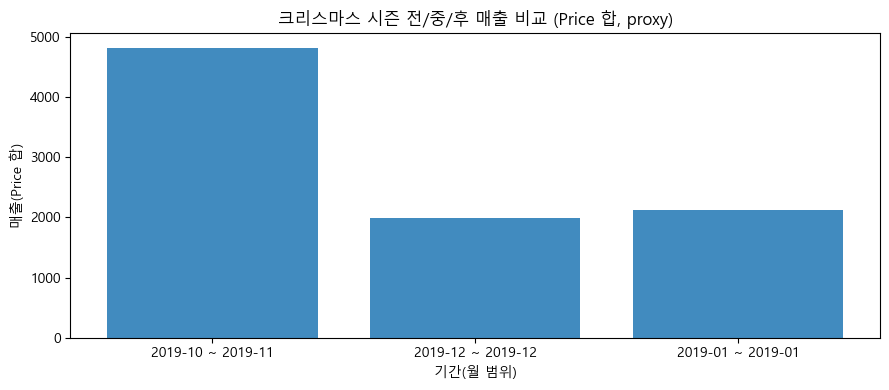

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

# --- 1) 기간 정의(월 기준) ---
# Pre: 10~11월, During: 12월, Post: 1월 (월만 있는 데이터 기준)
# ※ Year_Month가 "YYYY-MM" 형태라고 가정
ym = merged["Year_Month"].astype(str)
month_num = ym.str[-2:].astype(int)

merged["Xmas_Period"] = pd.Series(
    pd.NA, index=merged.index, dtype="object"
)

merged.loc[month_num.isin([10, 11]), "Xmas_Period"] = "Pre"
merged.loc[month_num.eq(12), "Xmas_Period"] = "During"
merged.loc[month_num.eq(1), "Xmas_Period"] = "Post"

# 분석 대상만
dfp = merged[merged["Xmas_Period"].isin(["Pre", "During", "Post"])].copy()

# --- 2) 각 기간의 실제 월 범위(몇월~몇월) 라벨 만들기 ---
# 각 Period별 min/max Year_Month 뽑기
period_range = (dfp.groupby("Xmas_Period")["Year_Month"]
                .agg(min_ym="min", max_ym="max")
                .to_dict("index"))

label_map = {
    "Pre":    f'{period_range["Pre"]["min_ym"]} ~ {period_range["Pre"]["max_ym"]}',
    "During": f'{period_range["During"]["min_ym"]} ~ {period_range["During"]["max_ym"]}',
    "Post":   f'{period_range["Post"]["min_ym"]} ~ {period_range["Post"]["max_ym"]}',
}

# --- 3) 집계 (시간 순서 고정!) ---
order = ["Pre", "During", "Post"]  # 원하는 시간 순서
period_sales = (dfp.groupby("Xmas_Period", as_index=False)
                .agg(Total_Sales=("Price", "sum"),
                     Txn_Count=("Price", "size"),
                     Buyer_Count=("Customer_Id", "nunique")))

# 시간 순서로 정렬
period_sales["Xmas_Period"] = pd.Categorical(period_sales["Xmas_Period"], categories=order, ordered=True)
period_sales = period_sales.sort_values("Xmas_Period")

# x축 라벨을 "몇월~몇월"로 변경
period_sales["Period_Label"] = period_sales["Xmas_Period"].map(label_map)

display(period_sales)

# --- 4) 시각화 ---
plt.figure(figsize=(9,4))
plt.bar(period_sales["Period_Label"], period_sales["Total_Sales"], alpha=0.85)
plt.title("크리스마스 시즌 전/중/후 매출 비교 (Price 합, proxy)")
plt.xlabel("기간(월 범위)")
plt.ylabel("매출(Price 합)")
plt.tight_layout()
plt.show()


,Year_Month,Total_Sales,Txn_Count,Buyer_Count
0,2019-01,2129.926131,80485,61901
1,2019-02,1989.217641,73073,57369
2,2019-03,2374.905504,81127,62360
3,2019-04,2703.443538,93289,70184
4,2019-05,2748.199469,98958,74332
5,2019-06,3088.776976,121068,89353
6,2019-07,2552.035334,114640,84700
7,2019-08,1943.422489,79587,60717
8,2019-09,2559.226862,77900,60685
9,2019-10,2358.486793,73259,58680


피크 월(매출 최대): 2019-06


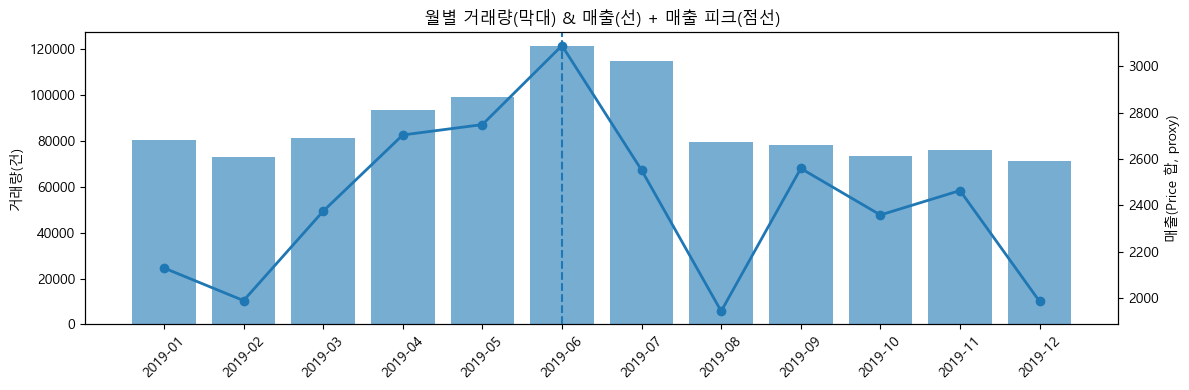

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

# 1) 월별 매출/거래량 집계
monthly = (merged.groupby("Year_Month", as_index=False)
           .agg(Total_Sales=("Price","sum"),
                Txn_Count=("Price","size"),
                Buyer_Count=("Customer_Id","nunique"))
          ).sort_values("Year_Month")

# 2) 피크(최대 매출 월) 찾기
peak_row = monthly.loc[monthly["Total_Sales"].idxmax()]
peak_ym = peak_row["Year_Month"]

display(monthly.tail(12))
print("피크 월(매출 최대):", peak_ym)

# 3) 시각화: 막대=거래량, 선=매출
fig, ax1 = plt.subplots(figsize=(12,4))
ax1.bar(monthly["Year_Month"], monthly["Txn_Count"], alpha=0.6, label="거래량(건)")
ax1.set_ylabel("거래량(건)")
ax1.tick_params(axis="x", rotation=45)

ax2 = ax1.twinx()
ax2.plot(monthly["Year_Month"], monthly["Total_Sales"], marker="o", linewidth=2, label="매출(Price 합, proxy)")
ax2.set_ylabel("매출(Price 합, proxy)")

# 피크 점선
ax2.axvline(x=peak_ym, linestyle="--")
ax2.set_title("월별 거래량(막대) & 매출(선) + 매출 피크(점선)")

plt.tight_layout()
plt.show()


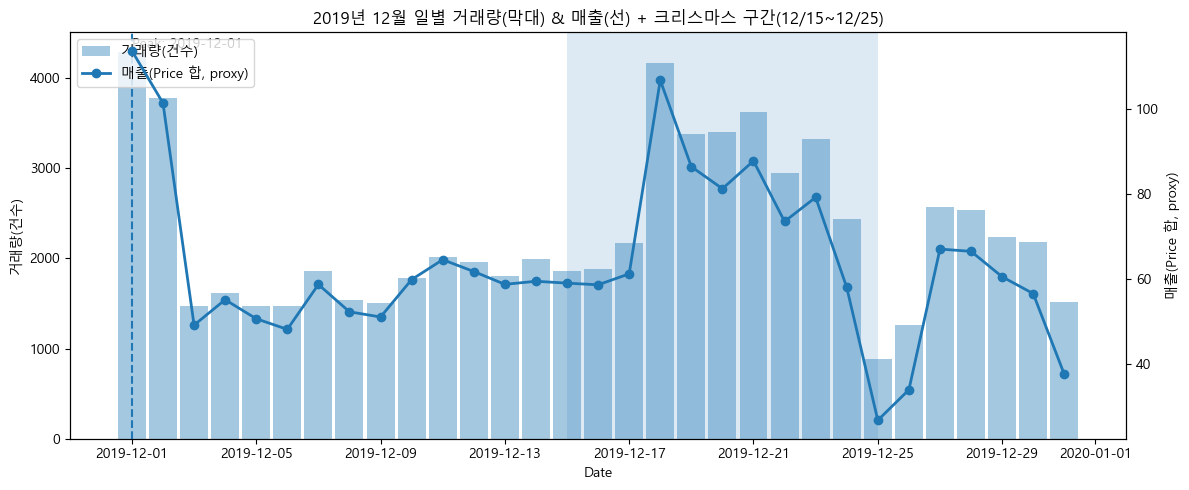

,Days,Txn_Count,Sales,Avg_Daily_Txn,Avg_Daily_Sales
Period,,,,,
Pre (12/01–12/14),14,28558,884.650846,2039.857143,63.189346
During (12/15–12/25),11,30078,778.693083,2734.363636,70.790280
Post (12/26–12/31),6,12305,322.148220,2050.833333,53.691370


In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 0) 크리스마스 시즌만 필터 (2019-12) ---
df = merged.copy()
df["T_Dat"] = pd.to_datetime(df["T_Dat"], errors="coerce")
df = df.dropna(subset=["T_Dat"])

dec = df[(df["T_Dat"] >= "2019-12-01") & (df["T_Dat"] <= "2019-12-31")].copy()

# --- 1) 일별 거래량(건수) & 매출(Price 합, proxy) ---
daily = (
    dec.groupby(dec["T_Dat"].dt.date)
       .agg(
           Txn_Count=("Price", "size"),
           Sales=("Price", "sum"),
       )
       .reset_index()
       .rename(columns={"T_Dat":"Date"})
)
daily["Date"] = pd.to_datetime(daily["Date"])

# --- 2) 구간 라벨링: Pre / During / Post ---
def label_period(d):
    if d <= pd.Timestamp("2019-12-14"):
        return "Pre (12/01–12/14)"
    elif d <= pd.Timestamp("2019-12-25"):
        return "During (12/15–12/25)"
    else:
        return "Post (12/26–12/31)"

daily["Period"] = daily["Date"].apply(label_period)

# --- 3) 일별 라인 + 크리스마스 구간 음영 ---
plt.figure(figsize=(12,5))
ax = plt.gca()

# 거래량: 막대(왼축)
ax.bar(daily["Date"], daily["Txn_Count"], width=0.9, alpha=0.4, label="거래량(건수)")

# 매출: 선(오른축) -> 막대에 가려지지 않게 zorder 올림
ax2 = ax.twinx()
ax2.plot(daily["Date"], daily["Sales"], marker="o", linewidth=2, label="매출(Price 합, proxy)", zorder=10)

# 크리스마스 러시 구간 강조
ax.axvspan(pd.Timestamp("2019-12-15"), pd.Timestamp("2019-12-25"), alpha=0.15)

# 매출 피크 점선
peak_date = daily.loc[daily["Sales"].idxmax(), "Date"]
ax2.axvline(peak_date, linestyle="--")
ax2.text(peak_date, daily["Sales"].max(), f"Peak: {peak_date.date()}", va="bottom")

ax.set_title("2019년 12월 일별 거래량(막대) & 매출(선) + 크리스마스 구간(12/15~12/25)")
ax.set_xlabel("Date")
ax.set_ylabel("거래량(건수)")
ax2.set_ylabel("매출(Price 합, proxy)")

# 범례 합치기
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h1+h2, l1+l2, loc="upper left")

plt.tight_layout()
plt.show()

# --- 4) 구간별 요약표 (Pre/During/Post 비교) ---
period_summary = (
    daily.groupby("Period")
         .agg(
             Days=("Date", "nunique"),
             Txn_Count=("Txn_Count", "sum"),
             Sales=("Sales", "sum"),
             Avg_Daily_Txn=("Txn_Count", "mean"),
             Avg_Daily_Sales=("Sales", "mean")
         )
         .reindex(["Pre (12/01–12/14)", "During (12/15–12/25)", "Post (12/26–12/31)"])
)

display(period_summary)


In [28]:
import pandas as pd
import matplotlib.pyplot as plt

df = merged.copy()
df["T_Dat"] = pd.to_datetime(df["T_Dat"], errors="coerce")
df = df.dropna(subset=["T_Dat", "Price"])

# 기간 정의
pre = df[(df["T_Dat"] >= "2019-12-01") & (df["T_Dat"] <= "2019-12-14")].copy()
during = df[(df["T_Dat"] >= "2019-12-15") & (df["T_Dat"] <= "2019-12-25")].copy()

# Product_Type 결측 방지
during["Product_Type"] = during["Product_Type"].fillna("UNKNOWN").astype(str).str.strip()
pre["Product_Type"] = pre["Product_Type"].fillna("UNKNOWN").astype(str).str.strip()

# 매출(Price 합) & 거래량(건수)
during_pt = (during.groupby("Product_Type")
                   .agg(Sales=("Price","sum"), Txn=("Price","size"))
                   .reset_index())

pre_pt = (pre.groupby("Product_Type")
               .agg(Pre_Sales=("Price","sum"), Pre_Txn=("Price","size"))
               .reset_index())

# 전(Pre) 대비 증가분까지 같이 보기
pt = during_pt.merge(pre_pt, on="Product_Type", how="left").fillna(0)
pt["Sales_Lift"] = pt["Sales"] - pt["Pre_Sales"]

# Top10: "During 매출" 기준으로 뽑기 (원하면 Sales_Lift로도 가능)
top10 = pt.sort_values("Sales", ascending=False).head(10)
display(top10)


,Product_Type,Sales,Txn,Pre_Sales,Pre_Txn,Sales_Lift
76,Sweater(252),122.215339,4624,141.979067,4477.0,-19.763729
85,Trousers(272),119.341966,3603,145.877610,4183.0,-26.535644
23,Dress(265),94.012474,2733,127.763508,3130.0,-33.751034
42,Jacket(262),36.838017,632,46.378576,643.0,-9.540559
70,Skirt(275),32.195678,984,39.409322,1082.0,-7.213644
9,Blouse(258),31.612712,1312,33.898610,1147.0,-2.285898
14,Bra(306),30.934119,1622,28.274881,1212.0,2.659237
8,Blazer(264),28.484729,634,24.738881,458.0,3.745848
83,Top(254),25.959746,1294,30.892780,1320.0,-4.933034
20,Coat(263),22.444424,261,25.079322,247.0,-2.634898


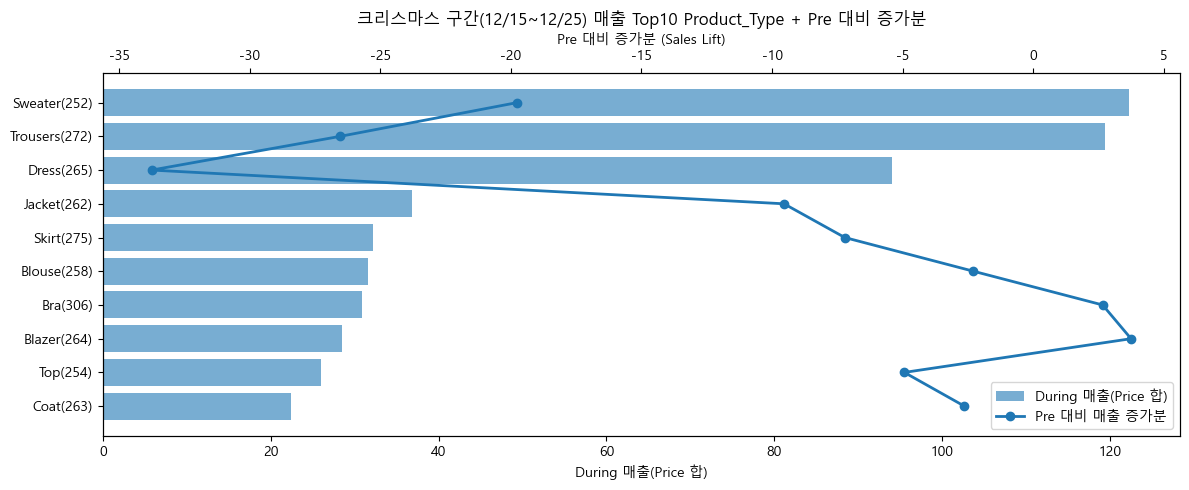

In [29]:
# 보기 좋게 정렬(매출 큰 순)
top10 = top10.sort_values("Sales", ascending=True)

fig, ax = plt.subplots(figsize=(12,5))

# 막대: During 매출
ax.barh(top10["Product_Type"], top10["Sales"], alpha=0.6, label="During 매출(Price 합)")

# 선(같은 축에 올리면 스케일이 너무 다를 수 있어서, 보통은 보조축)
ax2 = ax.twiny()
ax2.plot(top10["Sales_Lift"], top10["Product_Type"], marker="o", linewidth=2, label="Pre 대비 매출 증가분")

ax.set_title("크리스마스 구간(12/15~12/25) 매출 Top10 Product_Type + Pre 대비 증가분")
ax.set_xlabel("During 매출(Price 합)")
ax2.set_xlabel("Pre 대비 증가분 (Sales Lift)")

# 범례 합치기
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h1+h2, l1+l2, loc="lower right")

plt.tight_layout()
plt.show()


막대(오른쪽으로 길수록): 12/15~12/25 동안 매출(Price 합)이 큰 Product_Type

선(위쪽 축, Sales Lift): Pre(12/1~12/14) 대비 증가분
0보다 왼쪽(음수) = “크리스마스 구간에 오히려 줄었음”
0보다 오른쪽(양수) = “크리스마스 구간에 늘었음”

대부분 선이 음수
크리스마스 구간에 많이 팔리긴 했는데, 그 전(12/1~12/14)에도 이미 많이 팔리던 애들이라서 증가분 기준으로는 상승 기여가 아니라 상시 강자에 가까울듯?

반대로 Blazer(264) 같은 건 증가분이 +쪽으로 보이니까, 얘가 크리스마스 효과로 뜬 후보일 가능성이 큼.

,Product_Type,During_Sales,During_Txn,Pre_Sales,Pre_Txn,Sales_Lift,Txn_Lift
8,Blazer(264),28.484729,634.0,24.738881,458.0,3.745848,176.0
72,Shirt(259),21.797271,790.0,18.298746,622.0,3.498525,168.0
14,Bra(306),30.934119,1622.0,28.274881,1212.0,2.659237,410.0
3,Bag(66),8.237153,352.0,5.694644,188.0,2.542508,164.0
96,Underwear Bottom(286),16.491864,1266.0,14.373203,858.0,2.118661,408.0
20,Cardigan(245),12.845203,450.0,11.001949,324.0,1.843254,126.0
7,Bikini Top(298),3.754847,183.0,2.566407,145.0,1.188441,38.0
83,Swimsuit(57),2.904983,89.0,1.918424,57.0,0.986559,32.0
65,Pyjama Set(297),9.596102,368.0,9.077000,284.0,0.519102,84.0
84,Swimwear Bottom(59),2.409763,164.0,1.940932,143.0,0.468830,21.0


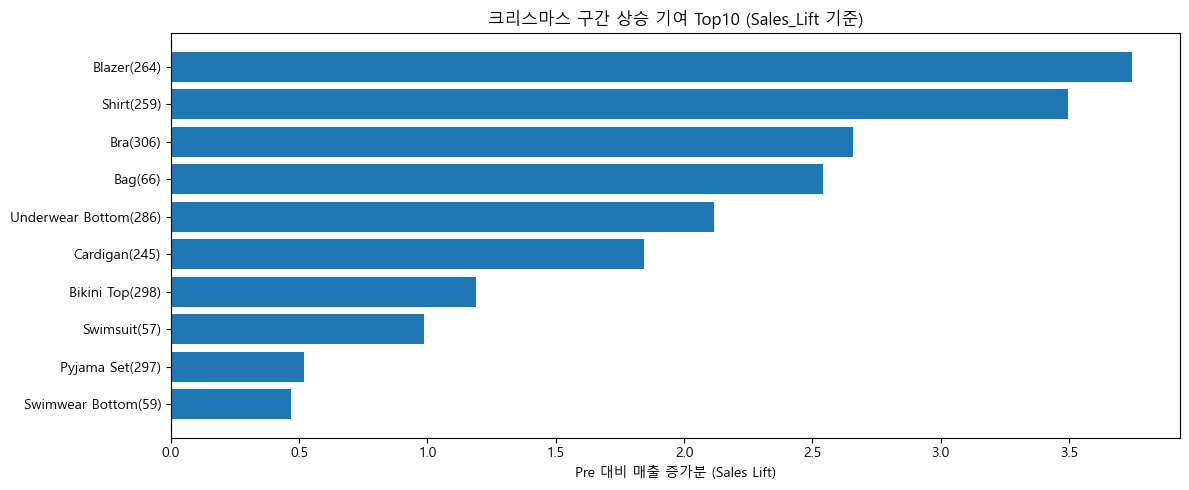

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

df = merged.copy()
df["T_Dat"] = pd.to_datetime(df["T_Dat"], errors="coerce")
df = df.dropna(subset=["T_Dat", "Price"])

pre = df[(df["T_Dat"] >= "2019-12-01") & (df["T_Dat"] <= "2019-12-14")].copy()
during = df[(df["T_Dat"] >= "2019-12-15") & (df["T_Dat"] <= "2019-12-25")].copy()

for d in (pre, during):
    d["Product_Type"] = d["Product_Type"].fillna("UNKNOWN").astype(str).str.strip()

pre_pt = pre.groupby("Product_Type").agg(Pre_Sales=("Price","sum"), Pre_Txn=("Price","size")).reset_index()
dur_pt = during.groupby("Product_Type").agg(During_Sales=("Price","sum"), During_Txn=("Price","size")).reset_index()

pt = dur_pt.merge(pre_pt, on="Product_Type", how="outer").fillna(0)
pt["Sales_Lift"] = pt["During_Sales"] - pt["Pre_Sales"]
pt["Txn_Lift"]   = pt["During_Txn"] - pt["Pre_Txn"]

# ✅ 상승 기여 Top10 = Sales_Lift 큰 순
top10_lift = pt.sort_values("Sales_Lift", ascending=False).head(10)
display(top10_lift)

# 시각화 (막대=Sales_Lift)
top10_lift = top10_lift.sort_values("Sales_Lift", ascending=True)

plt.figure(figsize=(12,5))
plt.barh(top10_lift["Product_Type"], top10_lift["Sales_Lift"])
plt.axvline(0, linestyle="--")
plt.title("크리스마스 구간 상승 기여 Top10 (Sales_Lift 기준)")
plt.xlabel("Pre 대비 매출 증가분 (Sales Lift)")
plt.tight_layout()
plt.show()


[Top10 Product_Type by Sales_Lift]


,Product_Type,Sales_Lift
0,Blazer(264),3.745848
1,Shirt(259),3.498525
2,Bra(306),2.659237
3,Bag(66),2.542508
4,Underwear Bottom(286),2.118661
5,Cardigan(245),1.843254
6,Bikini Top(298),1.188441
7,Swimsuit(57),0.986559
8,Pyjama Set(297),0.519102
9,Swimwear Bottom(59),0.468830


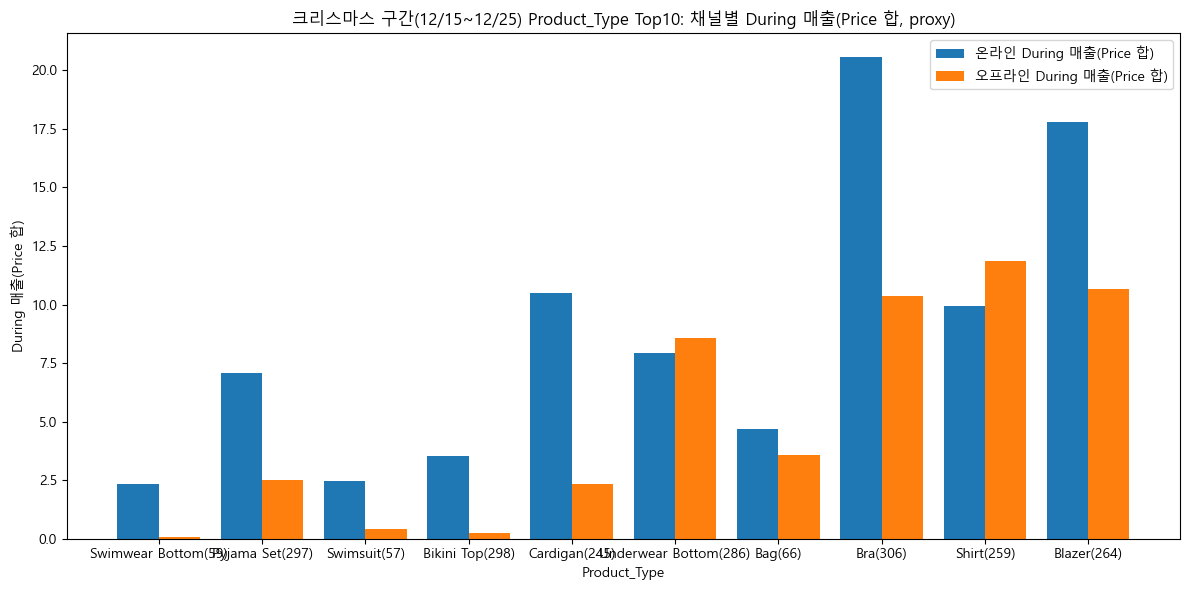

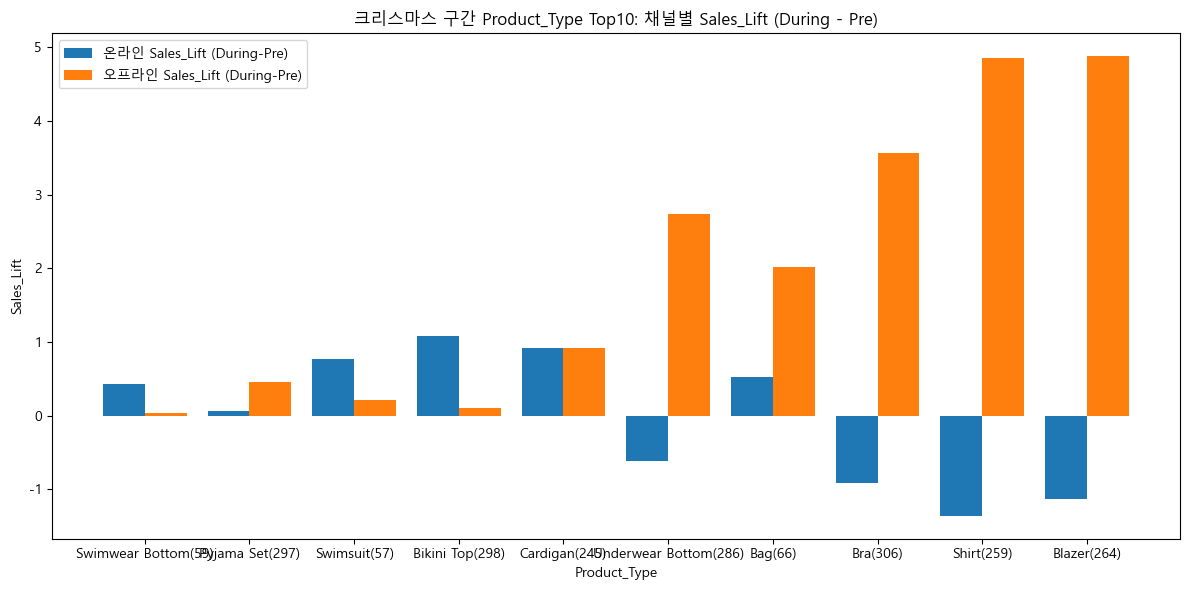


[Pre=0 & During>0 케이스(주의: 신규/희귀/표본 이슈 가능)]


,Product_Type,Pre_Sales,During_Sales,Is_Pre0_DuringPos


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 0) 기간 정의
# -----------------------------
# 2019년 크리스마스 기준
pre_start   = "2019-12-01"
pre_end     = "2019-12-14"
during_start= "2019-12-15"
during_end  = "2019-12-25"

df = merged.copy()

# 안전장치: dtype 보정
df["T_Dat"] = pd.to_datetime(df["T_Dat"], errors="coerce")
df["Price"] = pd.to_numeric(df["Price"], errors="coerce")
df["Product_Type"] = df["Product_Type"].astype(str)
df["Channel_Label"] = df["Channel_Label"].astype(str)

# -----------------------------
# 1) Pre / During 데이터 분리
# -----------------------------
pre = df[(df["T_Dat"] >= pre_start) & (df["T_Dat"] <= pre_end)].copy()
during = df[(df["T_Dat"] >= during_start) & (df["T_Dat"] <= during_end)].copy()

# 채널 값 정리(혹시 공백/대소문자 등)
def norm_channel(x):
    x = str(x).strip()
    if "온라인" in x or x.lower() == "online":
        return "온라인"
    if "오프라인" in x or x.lower() == "offline":
        return "오프라인"
    return x

pre["Channel_Label"] = pre["Channel_Label"].map(norm_channel)
during["Channel_Label"] = during["Channel_Label"].map(norm_channel)

# -----------------------------
# 2) Sales_Lift Top10(Product_Type) 뽑기 (전체 채널 합 기준)
# -----------------------------
pre_sum = pre.groupby("Product_Type")["Price"].sum()
during_sum = during.groupby("Product_Type")["Price"].sum()

lift = (during_sum - pre_sum).fillna(during_sum).fillna(0)  # pre 없으면 during로
top10_types = lift.sort_values(ascending=False).head(10).index.tolist()

print("[Top10 Product_Type by Sales_Lift]")
display(lift.loc[top10_types].to_frame("Sales_Lift").reset_index())

# -----------------------------
# 3) 채널별 During 매출 / Sales_Lift 계산
# -----------------------------
# During 채널별 매출
during_ch = (during[during["Product_Type"].isin(top10_types)]
             .groupby(["Product_Type","Channel_Label"])["Price"].sum()
             .unstack(fill_value=0))

# Pre 채널별 매출
pre_ch = (pre[pre["Product_Type"].isin(top10_types)]
          .groupby(["Product_Type","Channel_Label"])["Price"].sum()
          .unstack(fill_value=0))

# Sales_Lift(채널별) = During - Pre
lift_ch = (during_ch - pre_ch).fillna(during_ch).fillna(0)

# 채널 컬럼 순서 고정(없으면 만들어줌)
for col in ["온라인","오프라인"]:
    if col not in during_ch.columns: during_ch[col] = 0
    if col not in lift_ch.columns:   lift_ch[col] = 0

during_ch = during_ch[["온라인","오프라인"]]
lift_ch   = lift_ch[["온라인","오프라인"]]

# 정렬: 전체 Sales_Lift 큰 순서로
order = lift.loc[top10_types].sort_values(ascending=True).index  # barh라서 작은->큰이 보기 좋음
during_ch = during_ch.loc[order]
lift_ch   = lift_ch.loc[order]

# -----------------------------
# 4) 시각화 1: During 매출(채널별) - 예시처럼 그룹 막대
# -----------------------------
plt.figure(figsize=(12, 6))
x = np.arange(len(order))
w = 0.4

plt.bar(x - w/2, during_ch["온라인"].values, width=w, label="온라인 During 매출(Price 합)")
plt.bar(x + w/2, during_ch["오프라인"].values, width=w, label="오프라인 During 매출(Price 합)")

plt.xticks(x, order, rotation=0)
plt.title("크리스마스 구간(12/15~12/25) Product_Type Top10: 채널별 During 매출(Price 합, proxy)")
plt.ylabel("During 매출(Price 합)")
plt.xlabel("Product_Type")
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# 5) 시각화 2: Sales_Lift(채널별) - 그룹 막대
# -----------------------------
plt.figure(figsize=(12, 6))
plt.bar(x - w/2, lift_ch["온라인"].values, width=w, label="온라인 Sales_Lift (During-Pre)")
plt.bar(x + w/2, lift_ch["오프라인"].values, width=w, label="오프라인 Sales_Lift (During-Pre)")

plt.axvline(x=len(order)-1, alpha=0)  # (그냥 안전용, 없어도 됨)
plt.xticks(x, order, rotation=0)
plt.title("크리스마스 구간 Product_Type Top10: 채널별 Sales_Lift (During - Pre)")
plt.ylabel("Sales_Lift")
plt.xlabel("Product_Type")
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# 6) 체크: Pre=0인데 During>0 (신규/희귀 케이스)
# -----------------------------
pre_total = pre_sum.reindex(top10_types).fillna(0)
during_total = during_sum.reindex(top10_types).fillna(0)
new_like = (pre_total == 0) & (during_total > 0)

print("\n[Pre=0 & During>0 케이스(주의: 신규/희귀/표본 이슈 가능)]")
display(pd.DataFrame({
    "Product_Type": pre_total.index,
    "Pre_Sales": pre_total.values,
    "During_Sales": during_total.values,
    "Is_Pre0_DuringPos": new_like.values
}).query("Is_Pre0_DuringPos == True"))


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# datetime 안전장치
ts["T_Dat"] = pd.to_datetime(ts["T_Dat"], errors="coerce")
ts = ts.dropna(subset=["T_Dat"])

# 2019년 12월만
dec = ts[(ts["T_Dat"] >= "2019-12-01") & (ts["T_Dat"] < "2020-01-01")].copy()

# Xmas 기간 / Non-Xmas 기간
xmas = dec[(dec["T_Dat"] >= "2019-12-15") & (dec["T_Dat"] < "2019-12-26")].copy()
nonx = dec[~((dec["T_Dat"] >= "2019-12-15") & (dec["T_Dat"] < "2019-12-26"))].copy()

# 12월 전체 매출(Price 합) 기준으로 고객 세그먼트(Top20/Bottom20)
dec_cust = dec.groupby("Customer_Id", as_index=False)["Price"].sum().rename(columns={"Price":"Dec_Sales"})
q20 = dec_cust["Dec_Sales"].quantile(0.2)
q80 = dec_cust["Dec_Sales"].quantile(0.8)

def seg_dec(x):
    if x >= q80: return "Top20"
    if x <= q20: return "Bottom20"
    return "Mid60"

dec_cust["Segment"] = dec_cust["Dec_Sales"].apply(seg_dec)

# 구간별로 세그먼트 붙이기
xmas_seg = xmas.merge(dec_cust[["Customer_Id","Segment"]], on="Customer_Id", how="left")
nonx_seg = nonx.merge(dec_cust[["Customer_Id","Segment"]], on="Customer_Id", how="left")

# 구간별 요약
def seg_summary(df, label):
    out = (df.groupby("Segment", dropna=False)
             .agg(Sales=("Price","sum"),
                  Txn=("Price","size"),
                  Buyers=("Customer_Id","nunique"))
             .reset_index())
    out["Period"] = label
    out["Sales_Share_%"] = out["Sales"] / out["Sales"].sum() * 100
    return out

sum_x = seg_summary(xmas_seg, "Xmas(12/15-12/25)")
sum_n = seg_summary(nonx_seg, "NonXmas(others)")

seg_compare = pd.concat([sum_x, sum_n], ignore_index=True)
seg_compare


,Segment,Sales,Txn,Buyers,Period,Sales_Share_%
0,Bottom20,52.084949,5708,5588,Xmas(12/15-12/25),6.688765
1,Mid60,399.219338,16680,14683,Xmas(12/15-12/25),51.267867
2,Top20,327.388796,7690,4984,Xmas(12/15-12/25),42.043368
3,Bottom20,57.956051,6063,5968,NonXmas(others),4.802461
4,Mid60,587.528270,22911,20666,NonXmas(others),48.684846
5,Top20,561.314745,11889,7914,NonXmas(others),46.512693


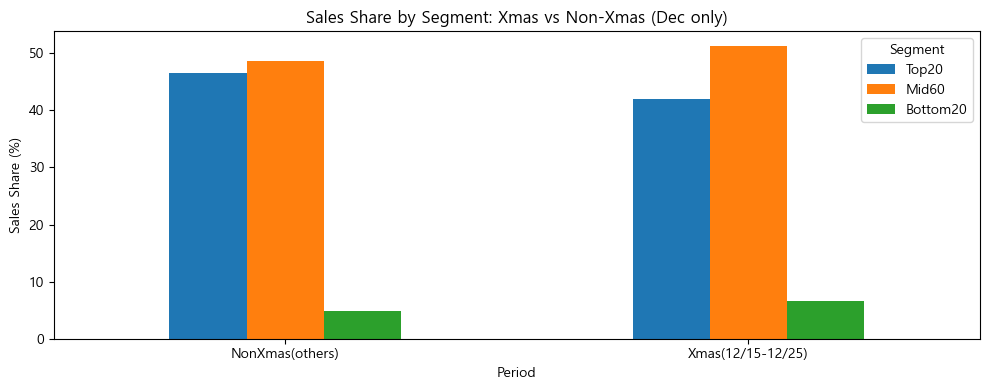

In [33]:
order_seg = ["Top20","Mid60","Bottom20"]
order_per = ["NonXmas(others)", "Xmas(12/15-12/25)"]

plot_df = seg_compare.copy()
plot_df = plot_df[plot_df["Segment"].isin(order_seg)]

plot_df["Segment"] = pd.Categorical(plot_df["Segment"], categories=order_seg, ordered=True)
plot_df["Period"] = pd.Categorical(plot_df["Period"], categories=order_per, ordered=True)
plot_df = plot_df.sort_values(["Period","Segment"])

pivot = plot_df.pivot(index="Period", columns="Segment", values="Sales_Share_%")

ax = pivot.plot(kind="bar", figsize=(10,4))
plt.title("Sales Share by Segment: Xmas vs Non-Xmas (Dec only)")
plt.ylabel("Sales Share (%)")
plt.xlabel("Period")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


date_col = T_Dat
price_col = Price
seg_col = Fn_Label


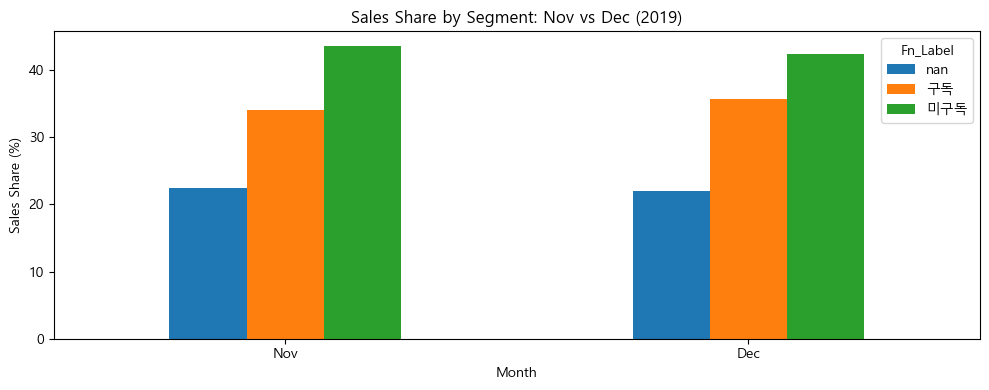

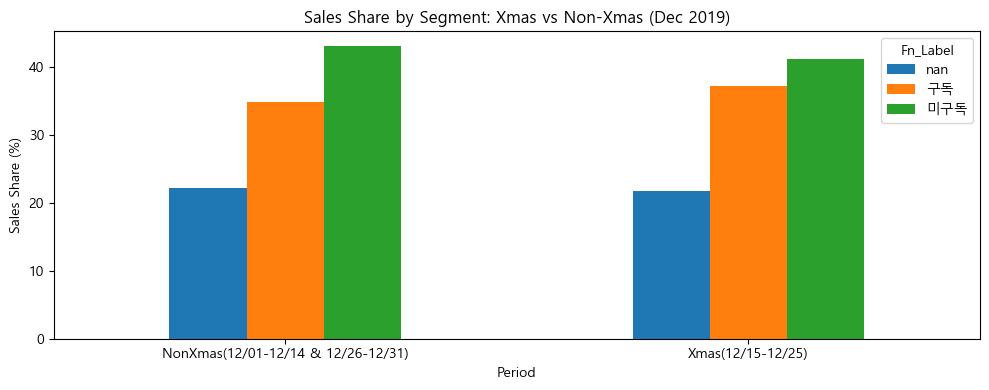

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

df = merged.copy()

# ---- 컬럼 자동 탐색 ----
date_col = "T_Dat" if "T_Dat" in df.columns else ("t_dat" if "t_dat" in df.columns else None)
price_col = "Price" if "Price" in df.columns else ("price" if "price" in df.columns else None)

seg_candidates = ["Segment", "segment", "Fn_Label", "fn_label", "Active_Label", "active_label"]
seg_col = next((c for c in seg_candidates if c in df.columns), None)

print("date_col =", date_col)
print("price_col =", price_col)
print("seg_col =", seg_col)

if date_col is None or price_col is None or seg_col is None:
    raise ValueError("필수 컬럼을 못 찾았어. 위 print 결과 보고 컬럼명을 직접 지정해줘.")

# ---- 날짜 변환 ----
df[date_col] = pd.to_datetime(df[date_col], errors="coerce")

# 2019년 11~12월
df_2019 = df[df[date_col].dt.year == 2019].copy()
df_11_12 = df_2019[df_2019[date_col].dt.month.isin([11, 12])].copy()
df_11_12["Month"] = df_11_12[date_col].dt.month

# ---- (그래프1) 11월 vs 12월 세그먼트 매출 비중 ----
month_seg_sales = (
    df_11_12.groupby(["Month", seg_col], dropna=False)[price_col]
    .sum()
    .reset_index(name="Sales")
)
month_total = month_seg_sales.groupby("Month")["Sales"].transform("sum")
month_seg_sales["Share"] = (month_seg_sales["Sales"] / month_total) * 100

p1 = month_seg_sales.pivot(index="Month", columns=seg_col, values="Share").reindex(index=[11, 12]).fillna(0)

plt.rcParams["axes.unicode_minus"] = False
ax = p1.plot(kind="bar", figsize=(10,4))
ax.set_title("Sales Share by Segment: Nov vs Dec (2019)")
ax.set_xlabel("Month")
ax.set_ylabel("Sales Share (%)")
ax.set_xticklabels(["Nov", "Dec"], rotation=0)
ax.legend(title=seg_col)
plt.tight_layout()
plt.show()

# ---- (그래프2) 12월 Xmas vs NonXmas (일 단위 있을 때만 의미 있음) ----
# 날짜가 월단위로 '2019-12'만 있는 경우엔 split 불가 → 그땐 스킵
has_day = df_2019[date_col].dt.day.nunique() > 1

if has_day:
    df_dec = df_2019[df_2019[date_col].dt.month == 12].copy()
    df_dec["Period"] = "NonXmas(12/01-12/14 & 12/26-12/31)"

    xmas_start = pd.Timestamp("2019-12-15")
    xmas_end   = pd.Timestamp("2019-12-25")
    mask_xmas = (df_dec[date_col] >= xmas_start) & (df_dec[date_col] <= xmas_end)
    df_dec.loc[mask_xmas, "Period"] = "Xmas(12/15-12/25)"

    period_seg_sales = (
        df_dec.groupby(["Period", seg_col], dropna=False)[price_col]
        .sum()
        .reset_index(name="Sales")
    )
    period_total = period_seg_sales.groupby("Period")["Sales"].transform("sum")
    period_seg_sales["Share"] = (period_seg_sales["Sales"] / period_total) * 100

    p2 = (
        period_seg_sales.pivot(index="Period", columns=seg_col, values="Share")
        .reindex(index=["NonXmas(12/01-12/14 & 12/26-12/31)", "Xmas(12/15-12/25)"])
        .fillna(0)
    )

    ax = p2.plot(kind="bar", figsize=(10,4))
    ax.set_title("Sales Share by Segment: Xmas vs Non-Xmas (Dec 2019)")
    ax.set_xlabel("Period")
    ax.set_ylabel("Sales Share (%)")
    ax.set_xticklabels(p2.index, rotation=0)
    ax.legend(title=seg_col)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ 날짜에 '일(day)' 정보가 없어서 Xmas(12/15~12/25) vs NonXmas 분리는 스킵했어. (월단위 데이터)")


In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# 0) df 지정
# =========================
df = merged  # <- 너 데이터프레임 이름

# =========================
# 1) 기본 준비
# =========================
date_col = "T_Dat" if "T_Dat" in df.columns else "t_dat"
price_col = "Price"
seg_col = "Segment"   # <- 필요하면 "Fn_Label" 등으로 바꿔

df = df.copy()
df[date_col] = pd.to_datetime(df[date_col], errors="coerce")

# 2019년 11월만
df_nov = df[(df[date_col].dt.year == 2019) & (df[date_col].dt.month == 11)].copy()

# (원하면 순서 고정)
seg_order = ["Top20", "Mid60", "Bottom20"]

# =========================
# 2) 11월 세그먼트 매출 비중
# =========================
nov_seg_sales = (
    df_nov.groupby(seg_col, dropna=False)[price_col]
    .sum()
    .reset_index(name="Sales")
)

nov_seg_sales["Share"] = nov_seg_sales["Sales"] / nov_seg_sales["Sales"].sum() * 100

# 정렬(가능하면 지정 순서대로)
if set(seg_order).issubset(set(nov_seg_sales[seg_col].astype(str))):
    nov_seg_sales[seg_col] = pd.Categorical(nov_seg_sales[seg_col], categories=seg_order, ordered=True)
    nov_seg_sales = nov_seg_sales.sort_values(seg_col)
else:
    nov_seg_sales = nov_seg_sales.sort_values("Share", ascending=False)

display(nov_seg_sales)

# =========================
# 3) 시각화 (11월만)
# =========================
plt.rcParams["axes.unicode_minus"] = False

plt.figure(figsize=(8,4))
plt.bar(nov_seg_sales[seg_col].astype(str), nov_seg_sales["Share"])
plt.title("Sales Share by Segment: Nov (2019)")
plt.xlabel("Segment")
plt.ylabel("Sales Share (%)")

for i, v in enumerate(nov_seg_sales["Share"]):
    plt.text(i, v, f"{v:.1f}%", ha="center", va="bottom")

plt.tight_layout()
plt.show()


KeyError: 'Segment'